In [1]:
# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Geolocation
from geopy.geocoders import Nominatim
import geopy.geocoders

# PDF handling
import pdfplumber

# SSL and certificates (used for secure requests)
import ssl
import certifi

# Machine learning and statistics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
from scipy import stats



In [2]:
# Mini ETL Pipeline

path = 'DS Programming Interview Question.pdf'

with pdfplumber.open(path) as pdf:
    page = pdf.pages[1]

    tables = page.extract_tables()

    dfs = []

    for table in tables:
        df = pd.DataFrame(table[1:], columns=table[0])
        dfs.append(df)

transactions_df = dfs[0]
customers_df = dfs[1]

In [3]:
# Display the first few rows of both DataFrames.
print("Transactions DataFrame (Preview):")
print(transactions_df.head(), '\n')

print("Customers DataFrame (Preview):")
print(customers_df.head())




Transactions DataFrame (Preview):
       txn_id account_id     use_case pay_amt   paid_time
0  1000000001    A000007  apple_store    5000  11/10/2020
1  1000000002    A000010     retailer    2853  19/11/2020
2  1000000003    A000003         toll      95  12/12/2020
3  1000000004    A000010     retailer    1522    1/1/2021
4  1000000005    A000011  apple_store    5000   25/2/2021 

Customers DataFrame (Preview):
  account_id          nric     latitude    longitude is_active
0    A000001  780805415511  3.131604296  101.7516121         1
1    A000002  941114105797  3.143431913  101.7416554         0
2    A000003  561101025240  3.157315399  101.7510118         1
3    A000006  790623085224  3.136489721  101.7471487         0
4    A000007  410313238221  3.159029946  101.7132453         1


## Data Preprocessing

In [4]:
print("Transactions DataFrame Datatypes (Preview):")
print(transactions_df.dtypes, '\n')

print("Customers DataFrame Datatypes (Preview):")
print(customers_df.dtypes)

Transactions DataFrame Datatypes (Preview):
txn_id        object
account_id    object
use_case      object
pay_amt       object
paid_time     object
dtype: object 

Customers DataFrame Datatypes (Preview):
account_id    object
nric          object
latitude      object
longitude     object
is_active     object
dtype: object


In [5]:
#Converting Data Types
transactions_df['txn_id'] = transactions_df['txn_id'].astype(str)  # Convert to string
transactions_df['account_id'] = transactions_df['account_id'].astype(str)  # Convert to string
transactions_df['use_case'] = transactions_df['use_case'].astype(str)  # Convert to string
transactions_df['pay_amt'] = transactions_df['pay_amt'].astype(float) #Convert to Float.
transactions_df['paid_time'] = pd.to_datetime(transactions_df['paid_time'], format='%d/%m/%Y') # Convert  to datetime.


customers_df['account_id'] = customers_df['account_id'].astype(str)  # Convert to string
customers_df['nric'] = customers_df['nric'].astype(str)  # Convert to string
customers_df['latitude'] = pd.to_numeric(customers_df['latitude'], errors='coerce')  # Convert to float
customers_df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')  # Convert to float

In [6]:
print("Transactions DataFrame Datatypes (Preview):")
print(transactions_df.dtypes, '\n')

print("Customers DataFrame Datatypes (Preview):")
print(customers_df.dtypes)

Transactions DataFrame Datatypes (Preview):
txn_id                object
account_id            object
use_case              object
pay_amt              float64
paid_time     datetime64[ns]
dtype: object 

Customers DataFrame Datatypes (Preview):
account_id     object
nric           object
latitude      float64
longitude     float64
is_active      object
dtype: object


In [7]:
#SSL Verification for Location Analysis
ctx = ssl._create_unverified_context(cafile=certifi.where())
geopy.geocoders.options.default_ssl_context = ctx


geolocator = Nominatim(scheme='https', user_agent='test')

# Auxilary Functions

def getGender(x):

    x = str(x)

    if len(x) < 2:
        return None 
    
    
    genderID = int(x[-1])
    result = genderID % 2 == 0

    if result == True:
        return 'F'
    return 'M' 


def getAge(x):

    x = str(x)

    current_year = datetime.now().year
    current_year_last_digits = current_year % 100




    if len(x) < 6:
        return None


    if int(x[:2]) <= current_year_last_digits:
        year = 2000 + int(x[:2])
    else:
        year = 1900 + int(x[:2])
    

    birth_year = datetime(year=year, month=1,day=1).year

    return current_year - birth_year


def getLocationDetails(lat, long):
    try:
        locator = Nominatim(scheme='https', user_agent='TNGActiveUsers')
        location = locator.reverse((lat, long))
        data = location.raw.get('address', {})
        return {
            'infra': data.get('type', 'Unavailable'),
            'suburb': data.get('suburb', 'Unavailable'),
            'city': data.get('city', 'Unavailable'),
            'postcode': data.get('postcode', 'Unavailable'),
            'rank': location.raw.get('place_rank', 'Unavailable')
        }
    except Exception as e:
        return {
            'infra': 'Unavailable',
            'suburb': 'Unavailable',
            'city': 'Unavailable',
            'postcode': 'Unavailable',
            'rank': 'Unavailable'
        }

    






In [8]:
#Extract Data To Make new Features For Customers

customers_df['gender'] = customers_df['nric'].apply(getGender)
customers_df['age'] = customers_df['nric'].apply(getAge)

locations = customers_df.apply(lambda row: getLocationDetails(row['latitude'], row['longitude']), axis=1)

location_details_df = pd.DataFrame(locations.tolist())
customers_df = pd.concat([customers_df, location_details_df], axis=1)

In [9]:
customers_df

,account_id,nric,latitude,longitude,is_active,gender,age,infra,suburb,city,postcode,rank
0,A000001,780805415511,3.131604,101.751612,1,M,46,Unavailable,Pandan Indah,Majlis Perbandaran Ampang Jaya,51500,26
1,A000002,941114105797,3.143432,101.741655,0,M,30,Unavailable,Unavailable,Kuala Lumpur,55100,30
2,A000003,561101025240,3.157315,101.751012,1,F,68,Unavailable,Unavailable,Majlis Perbandaran Ampang Jaya,50600,26
3,A000006,790623085224,3.136490,101.747149,0,F,45,Unavailable,Pandan Indah,Majlis Perbandaran Ampang Jaya,51500,30
4,A000007,410313238221,3.159030,101.713245,1,M,83,Unavailable,Bukit Bintang,Kuala Lumpur,50450,30
5,A000008,440404440000,3.177542,101.750841,1,F,80,Unavailable,Setiawangsa,Kuala Lumpur,54200,30
6,A000009,900622210013,3.177972,101.742602,0,M,34,Unavailable,Setiawangsa,Kuala Lumpur,54200,26
7,A000010,311222100067,3.197683,101.743804,1,M,93,Unavailable,Wangsa Maju,Kuala Lumpur,53300,30
8,A000011,310222100288,3.146901,101.736940,0,F,93,Unavailable,Kampung Pandan,Kuala Lumpur,50600,30
9,A000012,660622210002,3.150557,101.708989,0,F,58,Unavailable,Bukit Bintang,Kuala Lumpur,50540,30


In [10]:
# Creating new features for transactions.

# Count frequent transactions on the same day for each account
transactions_df['same_day_count'] = transactions_df.groupby(['account_id', 'paid_time'])['txn_id'].transform('nunique')

# Calculate the number of days since the last transaction
transactions_df = transactions_df.sort_values(by=['account_id', 'paid_time'])
transactions_df['days_since_last_txn'] = transactions_df.groupby('account_id')['paid_time'].diff().dt.days.fillna(0).astype(int)

# Add month column
transactions_df['month'] = transactions_df['paid_time'].dt.month

# Count transactions per month for each account
txn_count_per_month = (
    transactions_df.groupby(['account_id', 'month'])['txn_id']
    .count()
    .reset_index(name="txn_count_per_month")
)

# Merge monthly transaction count back to the main DataFrame
transactions_df = transactions_df.merge(txn_count_per_month, on=['account_id', 'month'], how='left')

# Drop the month column
transactions_df.drop(columns='month', inplace=True)


In [11]:
transactions_df.head()

,txn_id,account_id,use_case,pay_amt,paid_time,same_day_count,days_since_last_txn,txn_count_per_month
0,1000000010,A000001,retailer,2375.0,2021-08-03,1,0,2
1,1000000011,A000001,retailer,3500.0,2021-08-24,1,21,2
2,1000000007,A000002,postpaid_mobile,4690.0,2021-03-12,1,0,1
3,1000000003,A000003,toll,95.0,2020-12-12,1,0,2
4,1000000012,A000003,retailer,1520.0,2021-08-27,1,258,1


In [12]:
# Check for null values in both DataFrames
print("Null values in transactions_df:\n", transactions_df.isnull().sum(), "\n")
print("Null values in customers_df:\n", customers_df.isnull().sum())


Null values in transactions_df:
 txn_id                 0
account_id             0
use_case               0
pay_amt                0
paid_time              0
same_day_count         0
days_since_last_txn    0
txn_count_per_month    0
dtype: int64 

Null values in customers_df:
 account_id    0
nric          0
latitude      0
longitude     0
is_active     0
gender        0
age           0
infra         0
suburb        0
city          0
postcode      0
rank          0
dtype: int64


## Exploratory Data Analysis

### Univariate Analysis - Transactions 

In [13]:
transactions_df.describe(include='all')

,txn_id,account_id,use_case,pay_amt,paid_time,same_day_count,days_since_last_txn,txn_count_per_month
count,18,18,18,18.00000,18,18.0,18.000000,18.000000
unique,18,10,6,NaN,NaN,NaN,NaN,NaN
top,1000000010,A000010,retailer,NaN,NaN,NaN,NaN,NaN
freq,1,4,7,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,3964.00000,2021-06-08 12:00:00,1.0,59.111111,1.333333
min,NaN,NaN,NaN,95.00000,2020-10-11 00:00:00,1.0,0.000000,1.000000
25%,NaN,NaN,NaN,1520.50000,2021-02-28 00:00:00,1.0,0.000000,1.000000
50%,NaN,NaN,NaN,2591.00000,2021-07-01 00:00:00,1.0,0.000000,1.000000
75%,NaN,NaN,NaN,4392.50000,2021-10-16 12:00:00,1.0,98.500000,2.000000
max,NaN,NaN,NaN,16600.00000,2021-12-22 00:00:00,1.0,290.000000,2.000000


- The pay_amt column shows a wide range of transaction amounts, indicating diverse spending behavior, possibly driven by use cases or user demographics.
- A majority of transactions happen on weekdays, with less weekend activity.
Both use_case and transaction_category highlight shopping as the most common purpose for transactions.
- Users generally make 1 or 2 transactions per month, suggesting this dataset represents infrequent or occasional spenders.
- Diverse transaction behavior, from high-frequency users to occasional spenders.

/var/folders/g8/3b9mb2yj41v469g3trw2trx80000gp/T/ipykernel_71603/3170493164.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=use_case_counts.values, y=use_case_counts.index, palette='viridis')


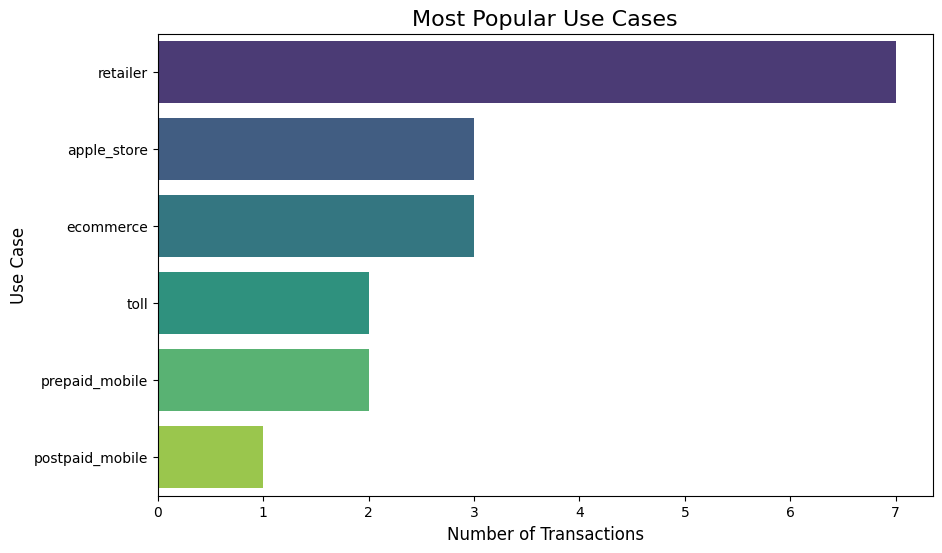

In [14]:
use_case_counts = transactions_df['use_case'].value_counts()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=use_case_counts.values, y=use_case_counts.index, palette='viridis')

# Add titles and labels
plt.title('Most Popular Use Cases', fontsize=16)
plt.xlabel('Number of Transactions', fontsize=12)
plt.ylabel('Use Case', fontsize=12)

# Show the plot
plt.show()

In [15]:
use_case_map = {

    'apple_store': 'shopping',
    'ecommerce': 'shopping',
    'retailer': 'shopping',
    'postpaid_mobile': 'bills',
    'prepaid_mobile': 'misc',
	'toll': 'misc'
}


transactions_df['transaction_category'] = transactions_df['use_case'].map(use_case_map)

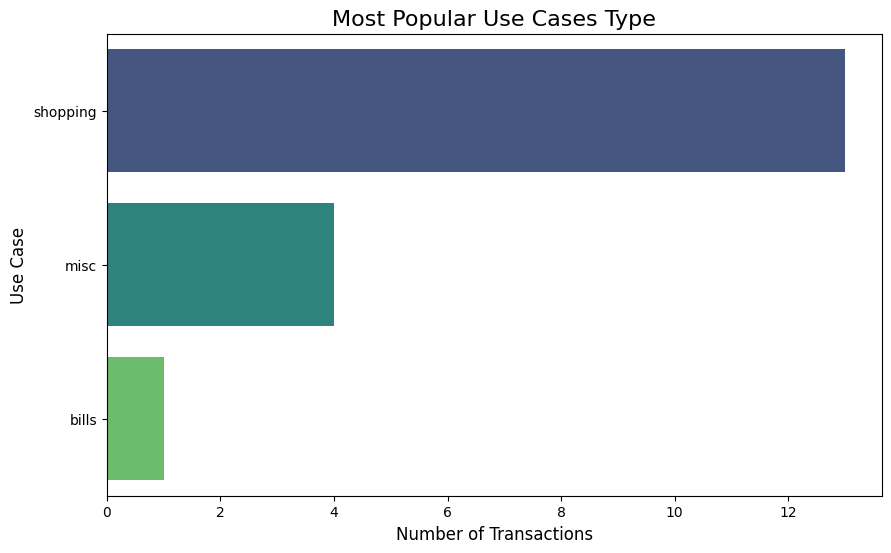

In [16]:

import warnings
warnings.filterwarnings('ignore')



use_case_type_counts = transactions_df['transaction_category'].value_counts()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=use_case_type_counts.values, y=use_case_type_counts.index, palette='viridis')

# Add titles and labels
plt.title('Most Popular Use Cases Type', fontsize=16)
plt.xlabel('Number of Transactions', fontsize=12)
plt.ylabel('Use Case', fontsize=12)

# Show the plot
plt.show()

- Users use the e-wallet mainly for shopping.

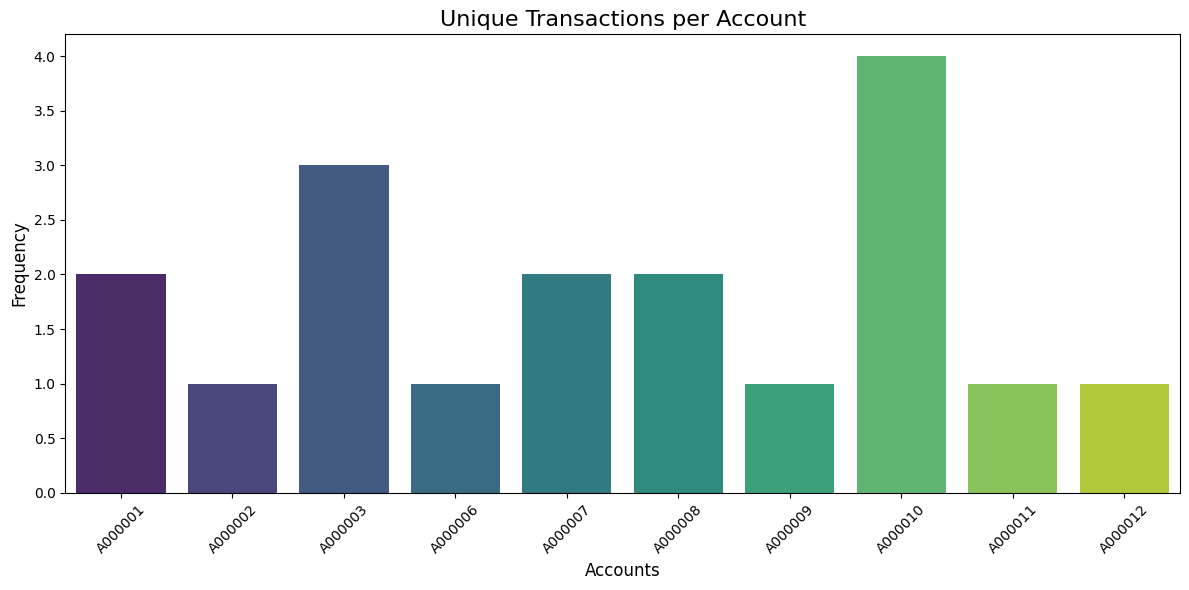

In [17]:
unique_txns_per_account = transactions_df.groupby('account_id')['txn_id'].nunique().reset_index()
unique_txns_per_account.rename(columns={'txn_id': 'unique_txns'}, inplace=True)


plt.figure(figsize=(12, 6))
sns.barplot(x='account_id', y='unique_txns', palette="viridis", data=unique_txns_per_account)

plt.title('Unique Transactions per Account', fontsize=16)
plt.xlabel('Accounts', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



- Total only 10 users half have made only 1 transaction, while the other have have made more than 1.

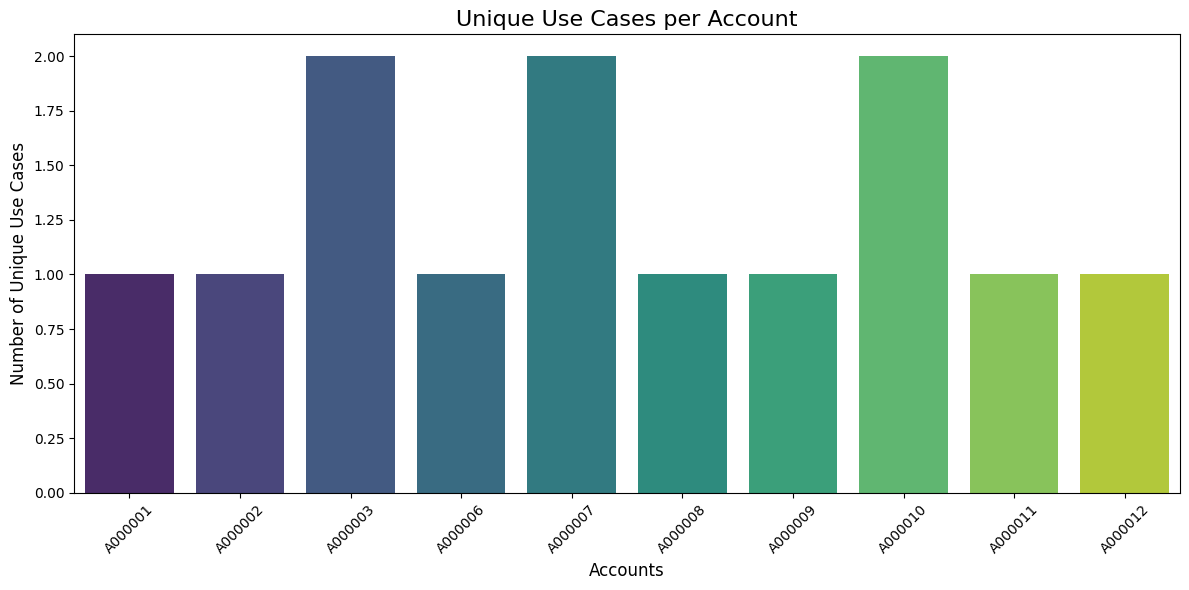

In [18]:
unique_use_cases_per_account = transactions_df.groupby('account_id')['use_case'].nunique().reset_index()
unique_use_cases_per_account.rename(columns={'use_case': 'unique_use_cases'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='account_id', y='unique_use_cases', palette="viridis", data=unique_use_cases_per_account)

plt.title('Unique Use Cases per Account', fontsize=16)
plt.xlabel('Accounts', fontsize=12)
plt.ylabel('Number of Unique Use Cases', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- Majority of users only use the e-wallet for 1 type of use case.

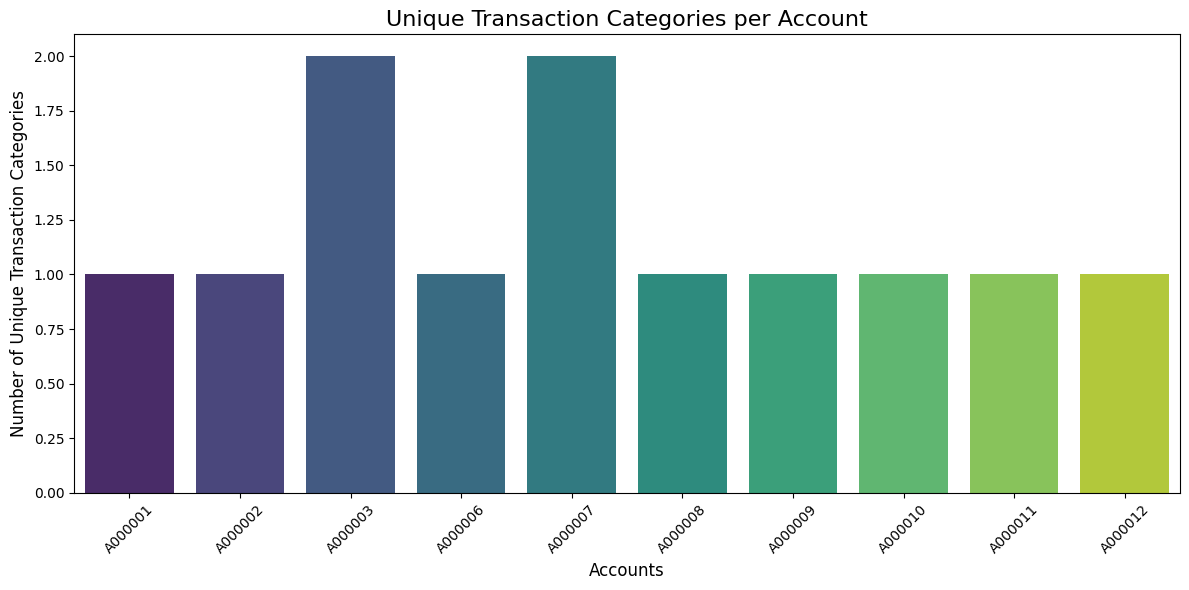

In [19]:
unique_transaction_categories_per_account = (
    transactions_df.groupby('account_id')['transaction_category']
    .nunique()
    .reset_index()
)
unique_transaction_categories_per_account.rename(
    columns={'transaction_category': 'unique_transaction_categories'}, inplace=True
)

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(
    x='account_id', 
    y='unique_transaction_categories', 
    palette="viridis", 
    data=unique_transaction_categories_per_account
)

# Add titles and labels
plt.title('Unique Transaction Categories per Account', fontsize=16)
plt.xlabel('Accounts', fontsize=12)
plt.ylabel('Number of Unique Transaction Categories', fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Only 2 users have more than one use case type.

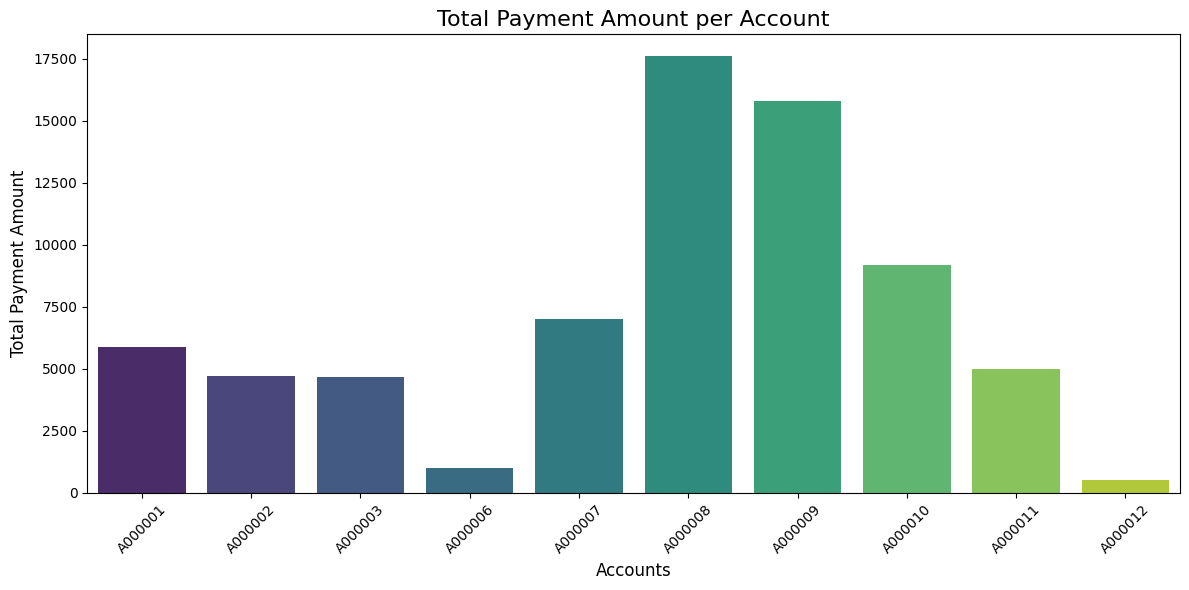

In [20]:
total_pay_amt_per_account = transactions_df.groupby('account_id')['pay_amt'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='account_id', y='pay_amt', palette="viridis", data=total_pay_amt_per_account)

plt.title('Total Payment Amount per Account', fontsize=16)
plt.xlabel('Accounts', fontsize=12)
plt.ylabel('Total Payment Amount', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Majority of the transaction amounts are more than RM 5,000.

In [21]:
transactions_df['is_weekend'] = (transactions_df['paid_time'].dt.weekday >= 5).astype(int)


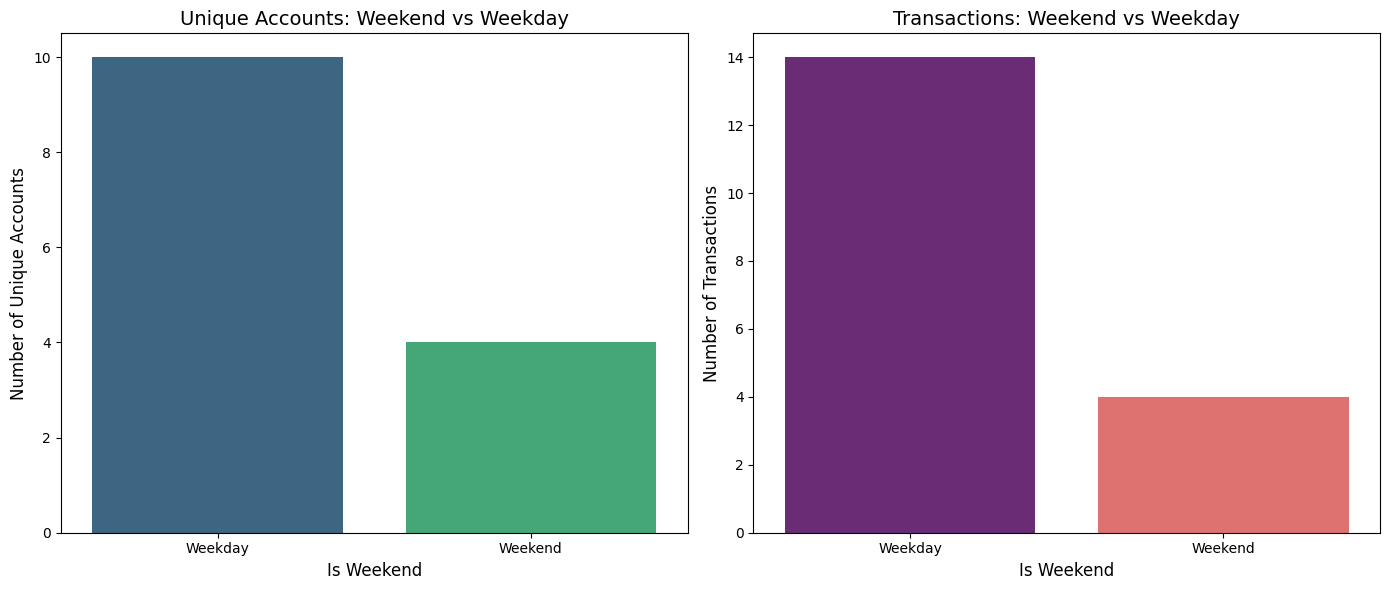

In [22]:
accounts_weekend_weekday = transactions_df.groupby('is_weekend')['account_id'].nunique().reset_index()
accounts_weekend_weekday.rename(columns={'account_id': 'unique_accounts'}, inplace=True)

transactions_weekend_weekday = transactions_df.groupby('is_weekend')['txn_id'].nunique().reset_index()
transactions_weekend_weekday.rename(columns={'txn_id': 'transaction_count'}, inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

sns.barplot(
    x='is_weekend', 
    y='unique_accounts', 
    palette="viridis", 
    data=accounts_weekend_weekday, 
    ax=axes[0]
)
axes[0].set_title('Unique Accounts: Weekend vs Weekday', fontsize=14)
axes[0].set_xlabel('Is Weekend', fontsize=12)
axes[0].set_ylabel('Number of Unique Accounts', fontsize=12)
axes[0].set_xticklabels(['Weekday', 'Weekend'])

sns.barplot(
    x='is_weekend', 
    y='transaction_count', 
    palette="magma", 
    data=transactions_weekend_weekday, 
    ax=axes[1]
)
axes[1].set_title('Transactions: Weekend vs Weekday', fontsize=14)
axes[1].set_xlabel('Is Weekend', fontsize=12)
axes[1].set_ylabel('Number of Transactions', fontsize=12)
axes[1].set_xticklabels(['Weekday', 'Weekend'])

plt.tight_layout()
plt.show()

- Majority of transactions happen on the weekday.

### Univariate Analysis - Customers

In [23]:
customers_df.describe(include='all')

,account_id,nric,latitude,longitude,is_active,gender,age,infra,suburb,city,postcode,rank
count,10,10,10.000000,10.000000,10,10,10.000000,10,10,10,10,10.000000
unique,10,10,NaN,NaN,2,2,NaN,1,6,2,7,NaN
top,A000001,780805415511,NaN,NaN,1,M,NaN,Unavailable,Pandan Indah,Kuala Lumpur,51500,NaN
freq,1,1,NaN,NaN,5,5,NaN,10,2,7,2,NaN
mean,NaN,NaN,3.157853,101.738785,NaN,NaN,63.000000,NaN,NaN,NaN,NaN,28.800000
std,NaN,NaN,0.020835,0.015351,NaN,NaN,23.762716,NaN,NaN,NaN,NaN,1.932184
min,NaN,NaN,3.131604,101.708989,NaN,NaN,30.000000,NaN,NaN,NaN,NaN,26.000000
25%,NaN,NaN,3.144299,101.738119,NaN,NaN,45.250000,NaN,NaN,NaN,NaN,27.000000
50%,NaN,NaN,3.153936,101.743203,NaN,NaN,63.000000,NaN,NaN,NaN,NaN,30.000000
75%,NaN,NaN,3.172914,101.749918,NaN,NaN,82.250000,NaN,NaN,NaN,NaN,30.000000


- Age distribution suggests an older population.
- Gender is balanced between male and female users.
- Users are mostly concentrated around Kuala Lumpur and its nearby suburbs, with latitude and longitude reinforcing this observation.

### Bivariate Analysis

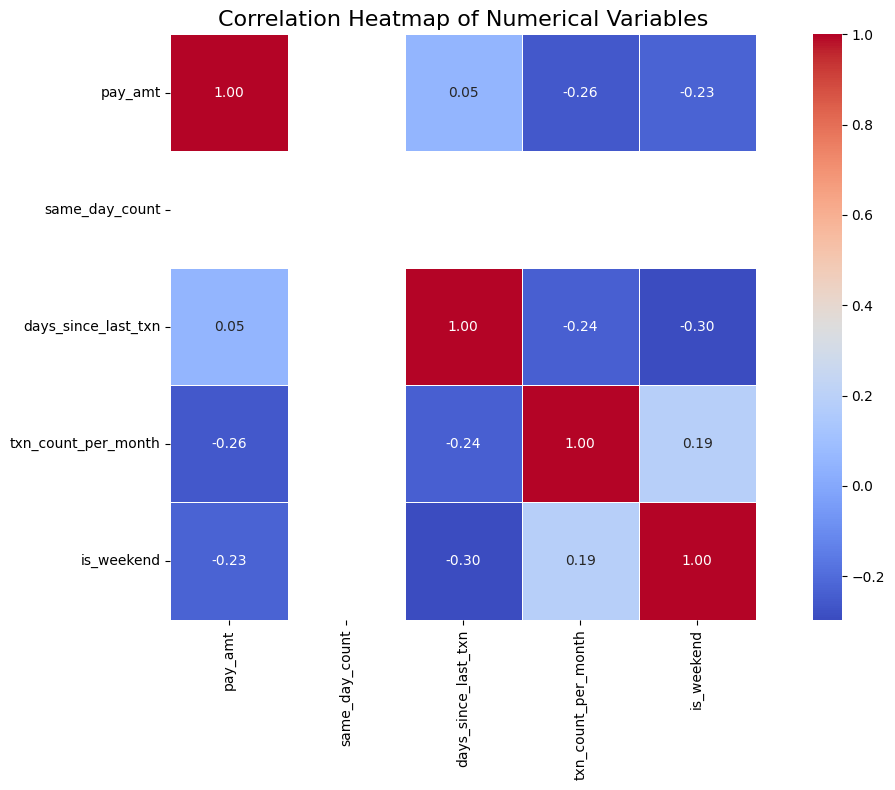

In [24]:
corr = transactions_df.select_dtypes(include='number').corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True, square=True)
plt.title('Correlation Heatmap of Numerical Variables', fontsize=16)
plt.tight_layout()
plt.show()

In [25]:
corr

,pay_amt,same_day_count,days_since_last_txn,txn_count_per_month,is_weekend
pay_amt,1.000000,NaN,0.050236,-0.256200,-0.227944
same_day_count,NaN,NaN,NaN,NaN,NaN
days_since_last_txn,0.050236,NaN,1.000000,-0.235657,-0.296141
txn_count_per_month,-0.256200,NaN,-0.235657,1.000000,0.188982
is_weekend,-0.227944,NaN,-0.296141,0.188982,1.000000


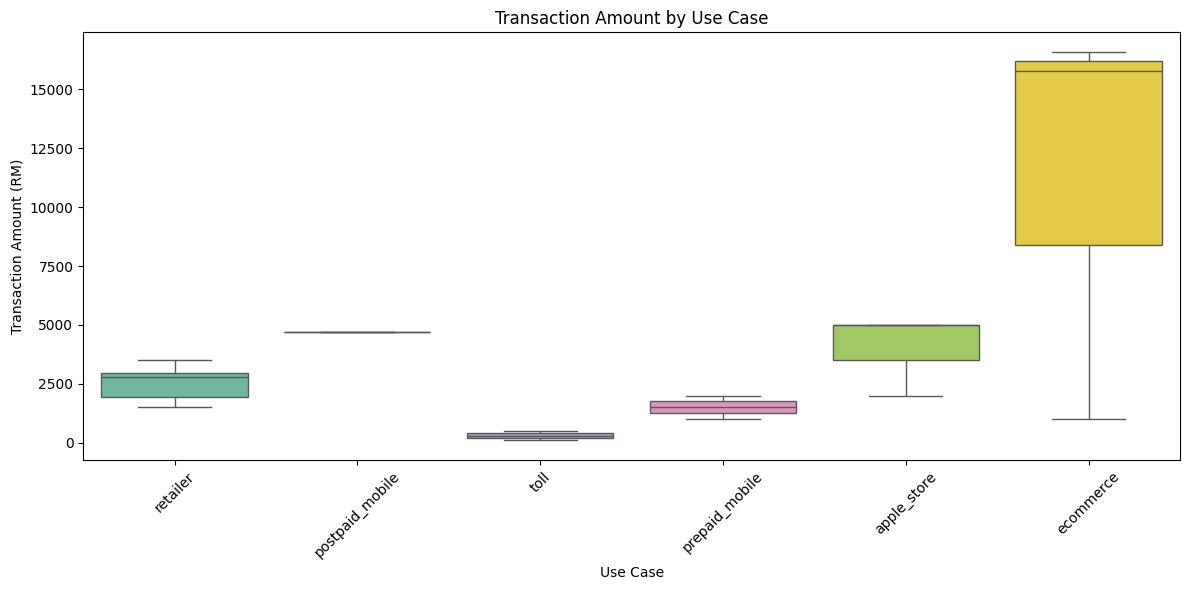

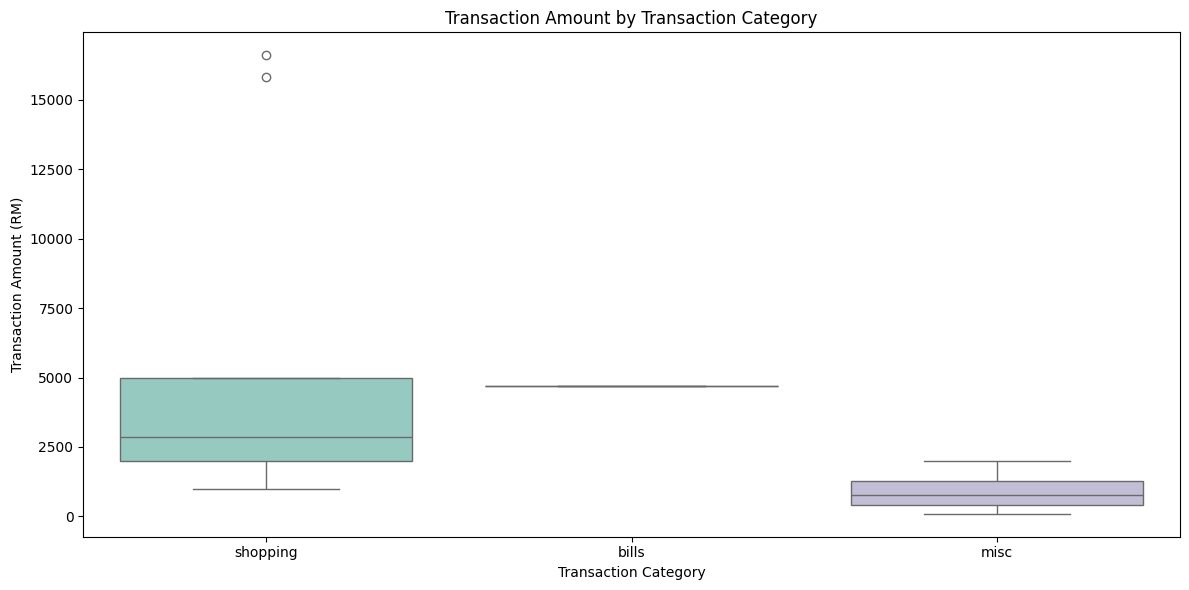

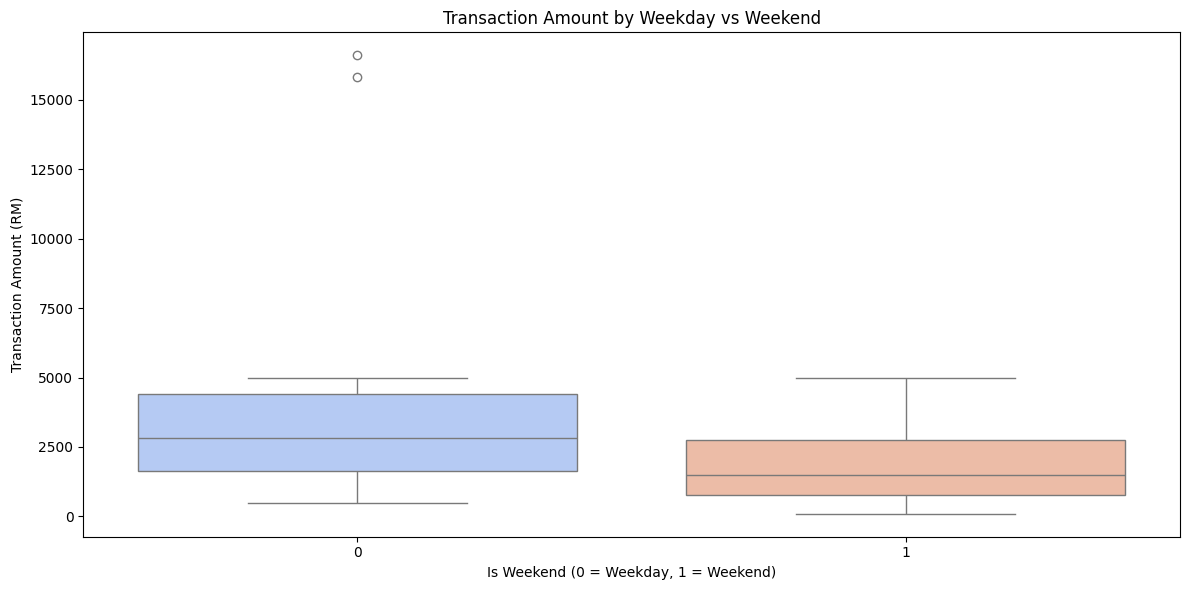

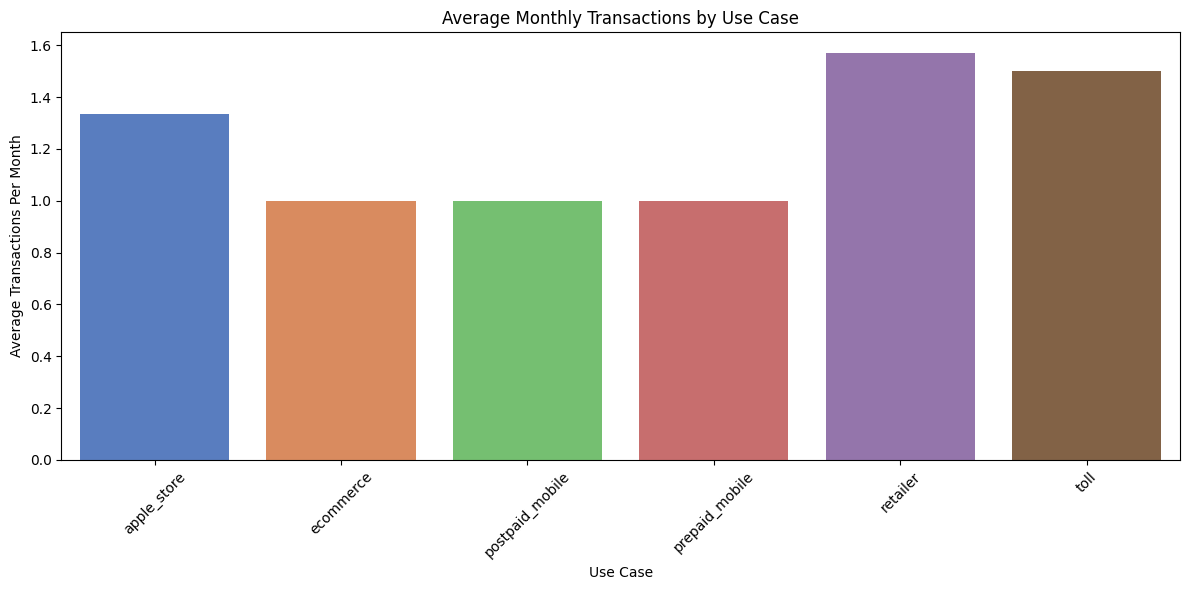

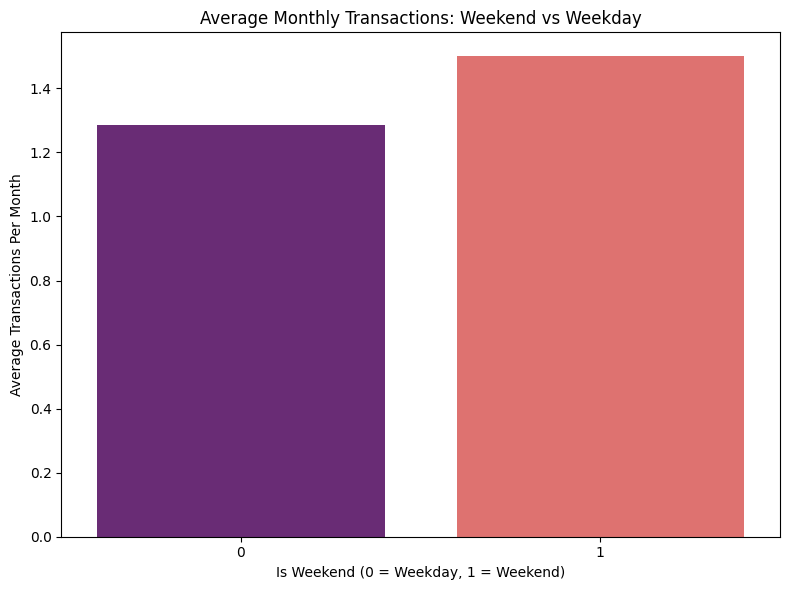

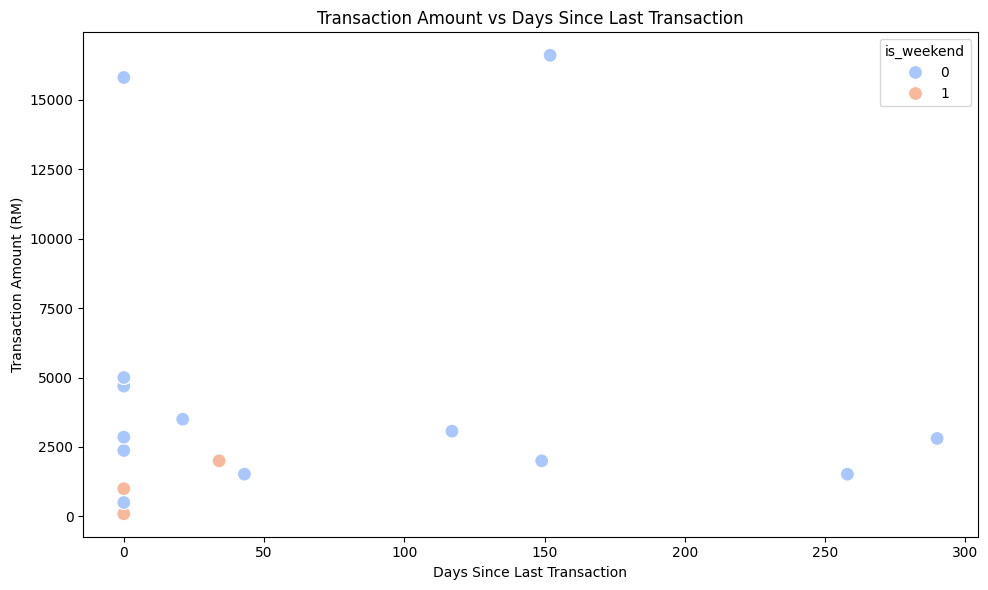

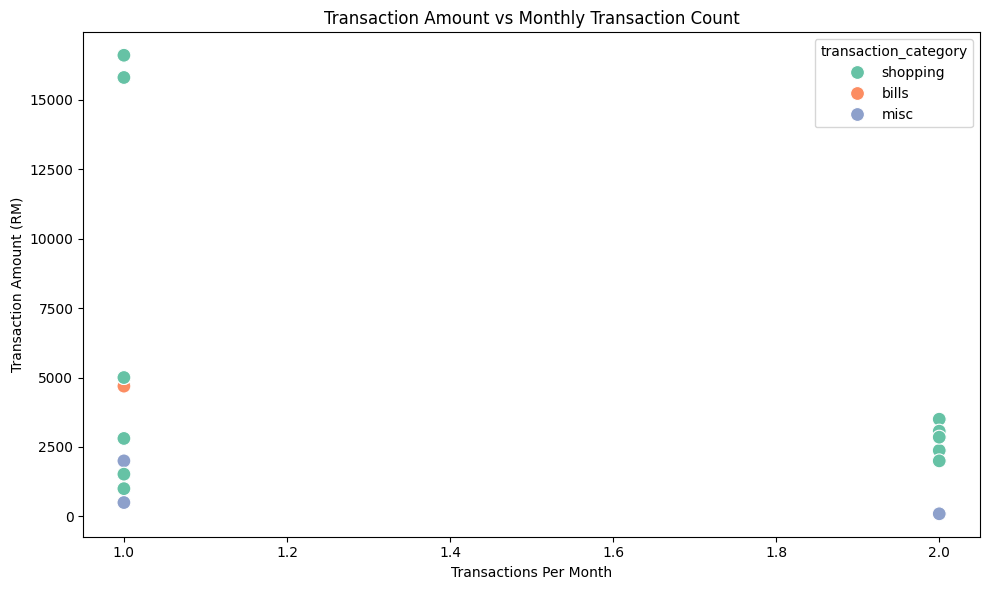

In [26]:
# Boxplot: pay_amt vs use_case
plt.figure(figsize=(12, 6))
sns.boxplot(x='use_case', y='pay_amt', data=transactions_df, palette="Set2")
plt.title('Transaction Amount by Use Case')
plt.xlabel('Use Case')
plt.ylabel('Transaction Amount (RM)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot: pay_amt vs transaction_category
plt.figure(figsize=(12, 6))
sns.boxplot(x='transaction_category', y='pay_amt', data=transactions_df, palette="Set3")
plt.title('Transaction Amount by Transaction Category')
plt.xlabel('Transaction Category')
plt.ylabel('Transaction Amount (RM)')
plt.tight_layout()
plt.show()

# Boxplot: pay_amt vs is_weekend
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_weekend', y='pay_amt', data=transactions_df, palette="coolwarm")
plt.title('Transaction Amount by Weekday vs Weekend')
plt.xlabel('Is Weekend (0 = Weekday, 1 = Weekend)')
plt.ylabel('Transaction Amount (RM)')
plt.tight_layout()
plt.show()

# Bar chart: txn_count_per_month vs use_case
use_case_txn_counts = transactions_df.groupby('use_case')['txn_count_per_month'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='use_case', y='txn_count_per_month', data=use_case_txn_counts, palette="muted")
plt.title('Average Monthly Transactions by Use Case')
plt.xlabel('Use Case')
plt.ylabel('Average Transactions Per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar chart: txn_count_per_month vs is_weekend
weekend_txn_counts = transactions_df.groupby('is_weekend')['txn_count_per_month'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='is_weekend', y='txn_count_per_month', data=weekend_txn_counts, palette="magma")
plt.title('Average Monthly Transactions: Weekend vs Weekday')
plt.xlabel('Is Weekend (0 = Weekday, 1 = Weekend)')
plt.ylabel('Average Transactions Per Month')
plt.tight_layout()
plt.show()

# Scatter plot: days_since_last_txn vs pay_amt
plt.figure(figsize=(10, 6))
sns.scatterplot(x='days_since_last_txn', y='pay_amt', data=transactions_df, hue='is_weekend', palette="coolwarm", s=100)
plt.title('Transaction Amount vs Days Since Last Transaction')
plt.xlabel('Days Since Last Transaction')
plt.ylabel('Transaction Amount (RM)')
plt.tight_layout()
plt.show()

# Scatter plot: txn_count_per_month vs pay_amt
plt.figure(figsize=(10, 6))
sns.scatterplot(x='txn_count_per_month', y='pay_amt', data=transactions_df, hue='transaction_category', palette="Set2", s=100)
plt.title('Transaction Amount vs Monthly Transaction Count')
plt.xlabel('Transactions Per Month')
plt.ylabel('Transaction Amount (RM)')
plt.tight_layout()
plt.show()

- E-commerce accounts for the highest total payment volume, whereas postpaid mobile transactions have the lowest payment value.
- Shopping transactions exhibit the highest single-transaction spend, with outliers indicating a few exceptionally large transactions.
- Users generally spend more on weekdays, though there are outliers suggesting some notably high-value transactions.
- Retailers experience the highest average number of transactions per month, indicating frequent customer engagement.
- Only one user with more than one transaction per month also makes purchases on the weekends.
- Users who make smaller transactions tend to have longer intervals between transactions, suggesting a correlation between high transaction amounts and less frequent purchases.

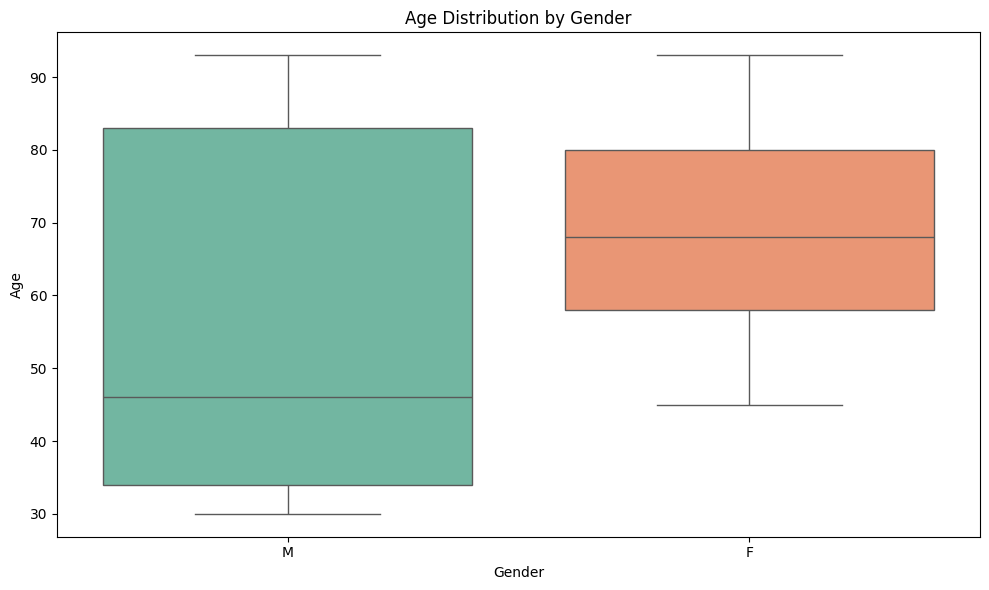

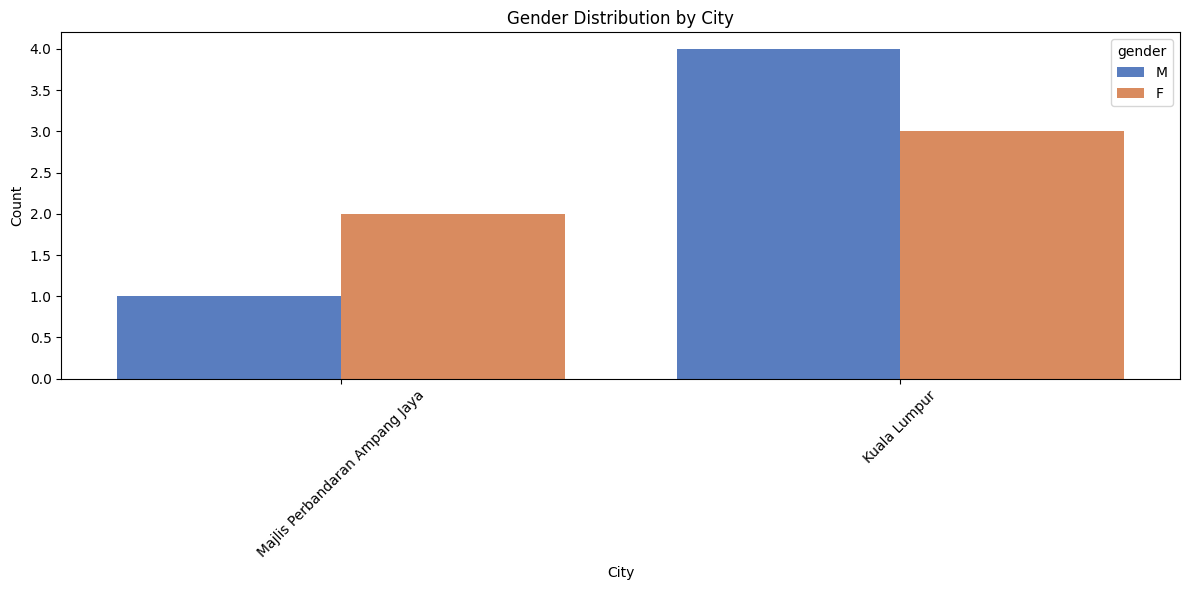

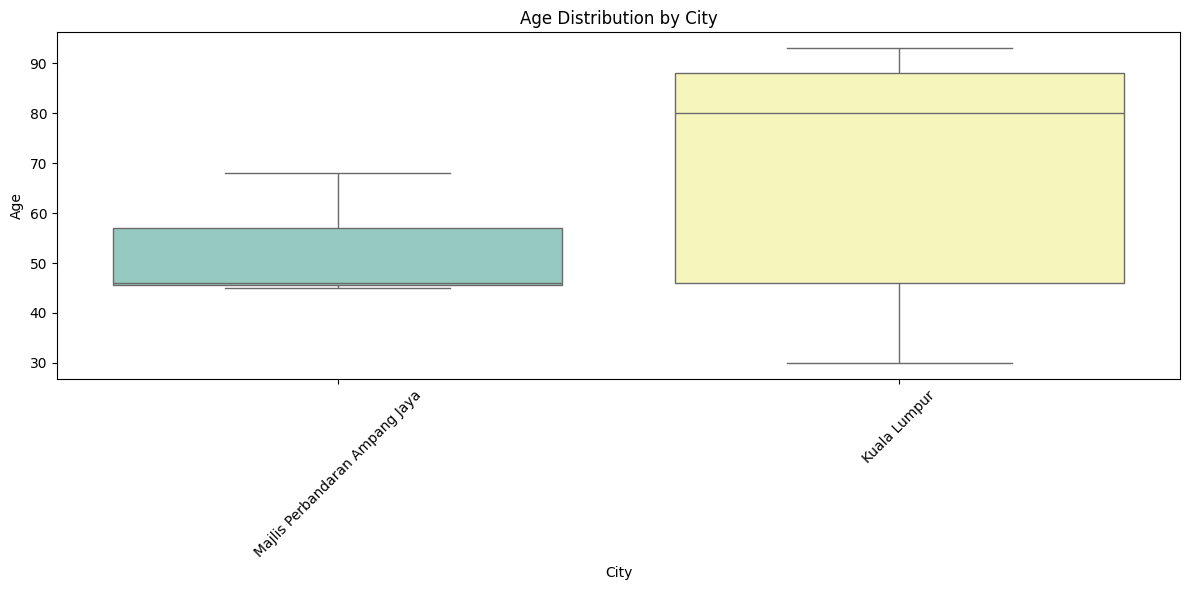

In [27]:
# 1. Age vs. Gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='age', data=customers_df, palette='Set2')
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.tight_layout()
plt.show()


# 6. City vs. Gender
plt.figure(figsize=(12, 6))
sns.countplot(x='city', hue='gender', data=customers_df, palette='muted')
plt.title('Gender Distribution by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='age', data=customers_df, palette='Set3')
plt.title('Age Distribution by City')
plt.xlabel('City')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Male users tend to be younger than the female users.
- More males live in KL than Ampang.
- More younger users in KL than Ampang.

## Multivariate Analysis

In [28]:
agg_txn_df = transactions_df.groupby('account_id').agg(
    total_transactions=('txn_id', 'count'),
    total_spent=('pay_amt', 'sum'),
    avg_transaction_amount=('pay_amt', 'mean'),
    total_weekend_transactions=('is_weekend', 'sum'),
    total_same_day_transactions=('same_day_count', 'sum'),
    avg_days_since_last_txn=('days_since_last_txn', 'mean'),
    avg_txn_count_per_month=('txn_count_per_month', 'mean'),
    unique_use_cases=('use_case', 'nunique'),
    unique_transaction_categories=('transaction_category', 'nunique')
).reset_index()

# 2. Pivot the 'use_case' into columns, aggregating txn_id uniqueness
pivot_df = transactions_df.pivot_table(
    index='account_id', 
    columns='transaction_category', 
    values='txn_id', 
    aggfunc=pd.Series.nunique,  # Count unique txn_ids for each use_case
    fill_value=0                 # Replace NaN with 0 for missing data
)

# Merge the aggregated data and pivot table into one DataFrame
final_df = agg_txn_df.merge(pivot_df, on='account_id', how='left')


In [29]:
df = customers_df.merge(final_df, on='account_id', how='left')

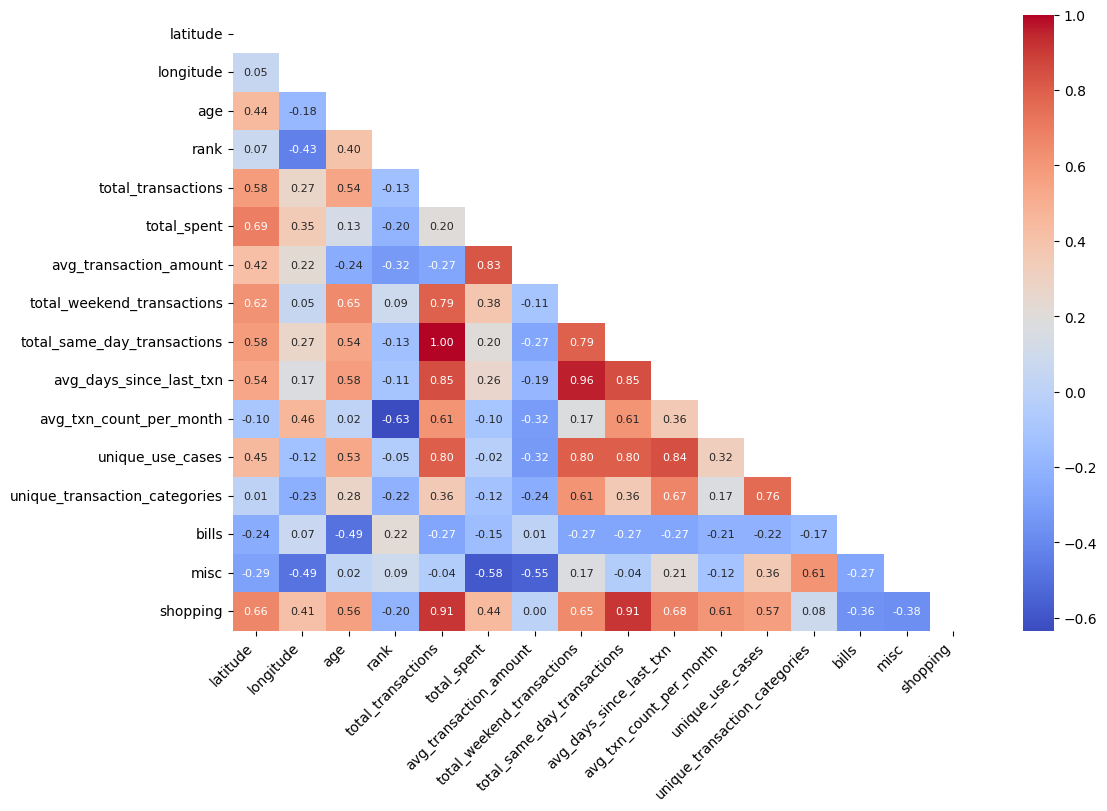

In [30]:
num_features = df.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = num_features.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 8}, mask=mask)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

- High correlations between Total Transactions and Total Spent, Same Day Transactions, and Weekend Transactions.
- Age is positively correlated with Total Transactions, Total Weekend Transactions, and Total Same Day Transactions.
- There is also a relationship between age and transaction category which show that as age increases the tendency to use the ewallet for shopping also increases.
- Shopping is strongly correlated with Total Same Day Transactions and Total Weekend Transactions, implying that shopping drives transaction behavior.
- Unique Use Cases and Unique Transaction Categories have a significant positive relationship with each other and with transaction frequency.
- Days Since Last Transaction shows negative correlations with spending and transaction frequency, but positive correlations with use case diversity.

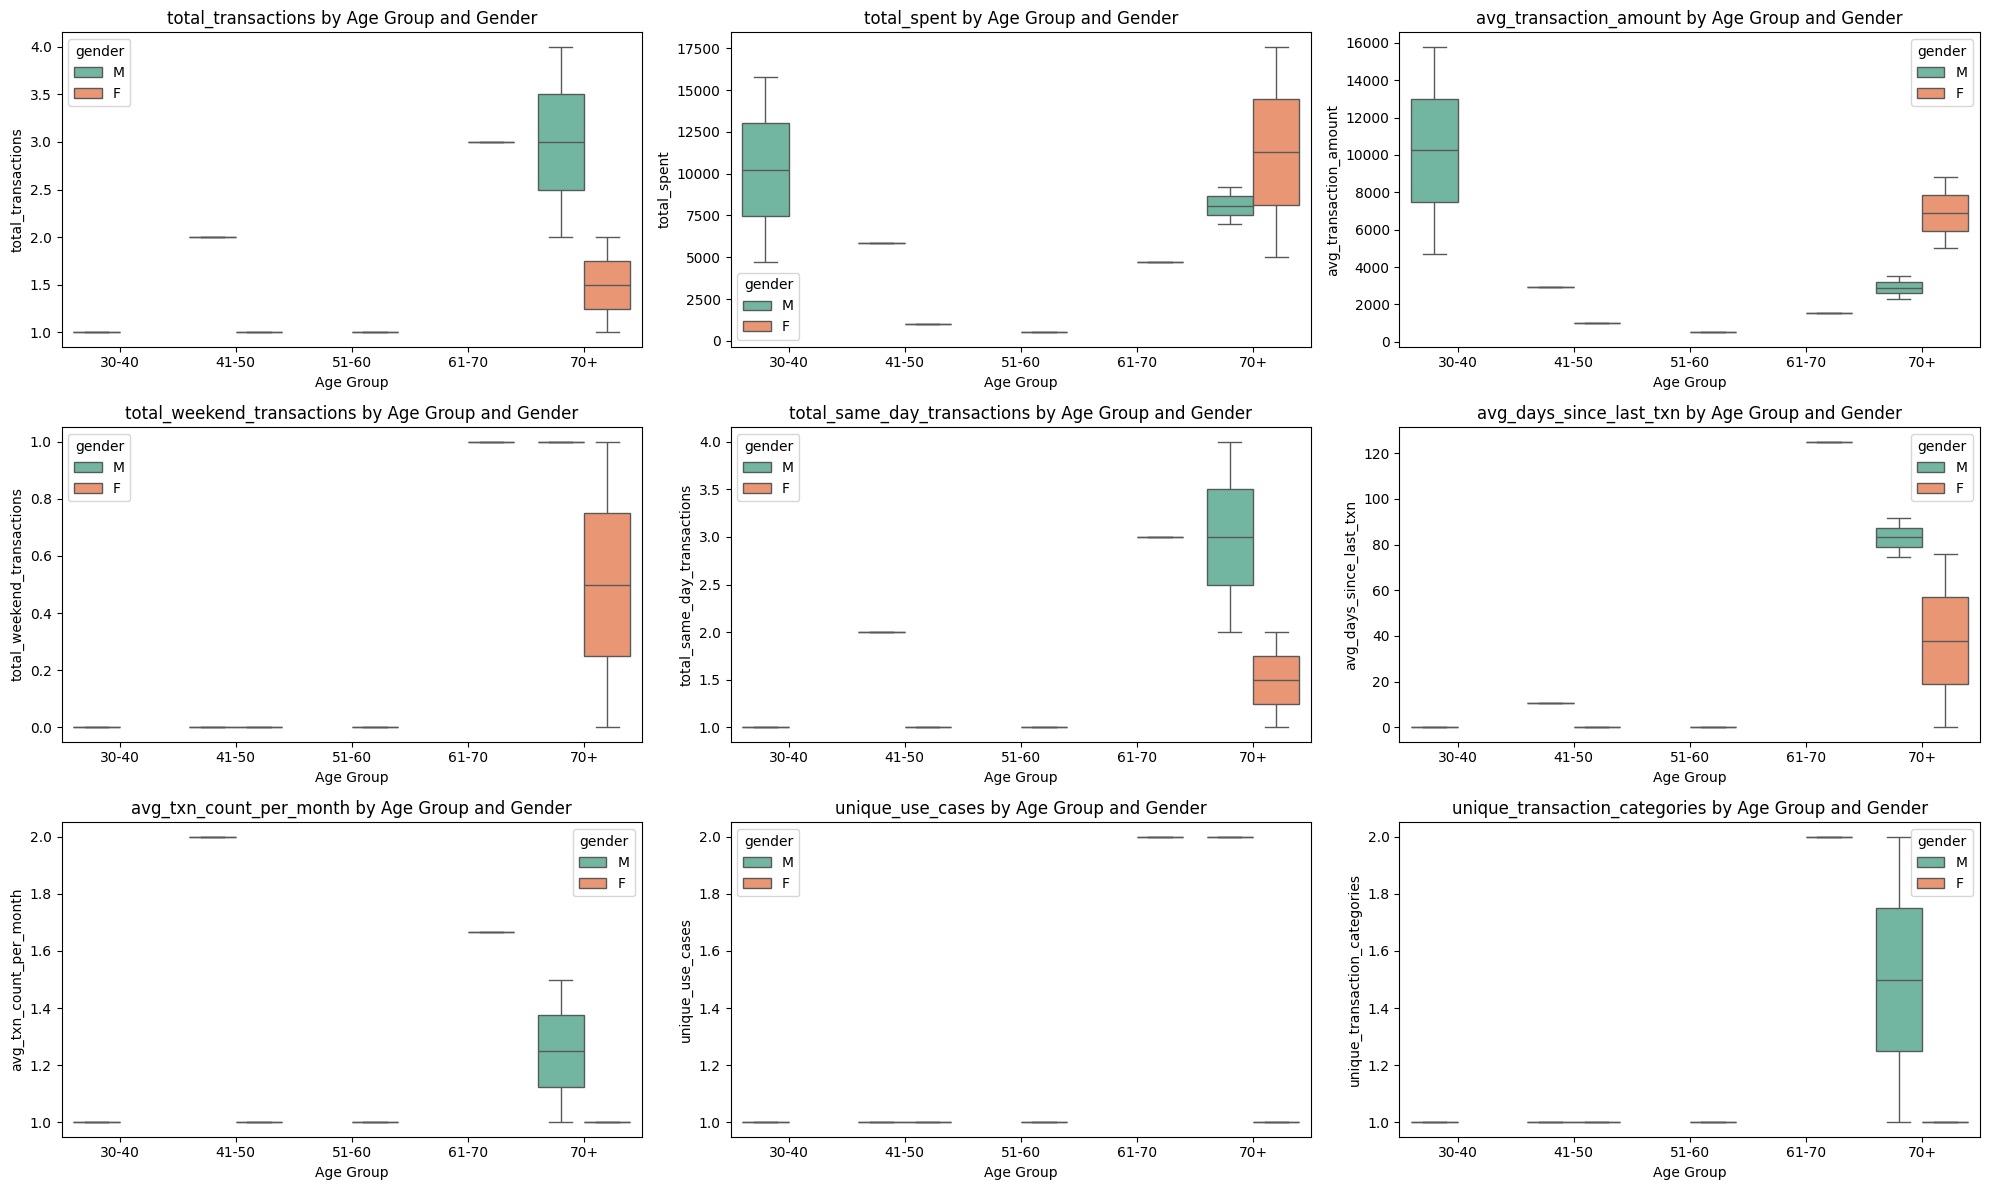

In [31]:
bins = [29, 40, 50, 60, 70, 100]  # Adjusted to suit available ages
labels = ['30-40', '41-50', '51-60', '61-70', '70+']

# Create the age group column
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

continuous_vars = ['total_transactions', 'total_spent', 'avg_transaction_amount', 'total_weekend_transactions', 'total_same_day_transactions', 'avg_days_since_last_txn', 'avg_txn_count_per_month', 'unique_use_cases', 'unique_transaction_categories']


plt.figure(figsize=(20, 12))

# Loop through each continuous variable and plot a boxplot
for i, var in enumerate(continuous_vars):
    plt.subplot(3, 3, i+1)  # Creates a 3x3 grid of subplots
    sns.boxplot(x='age_group', y=var, hue='gender', data=df, palette='Set2')
    plt.title(f'{var} by Age Group and Gender')
    plt.xlabel('Age Group')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

## Feature Selection 

In [32]:

from scipy.stats import pointbiserialr, chi2_contingency

df['is_active'] = df['is_active'].astype(int)  

categorical_vars = ['gender', 'city', 'postcode']
for var in categorical_vars:
    df[var] = pd.factorize(df[var])[0]

continuous_vars = ['age', 'rank', 'total_transactions', 'total_spent', 
                   'avg_transaction_amount', 'total_weekend_transactions', 
                   'total_same_day_transactions', 'avg_days_since_last_txn', 
                   'avg_txn_count_per_month', 'unique_use_cases', 
                   'unique_transaction_categories', 'bills', 'misc', 'shopping']

point_biserial_results = []
for var in continuous_vars:
    correlation, p_value = pointbiserialr(df['is_active'], df[var])
    point_biserial_results.append({'variable': var, 'test': 'Point-Biserial', 
                                   'correlation': correlation, 'p_value': p_value})

chi_square_results = []
for var in categorical_vars:
    contingency_table = pd.crosstab(df['is_active'], df[var])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results.append({'variable': var, 'test': 'Chi-Square', 
                               'chi2': chi2, 'p_value': p, 'dof': dof})

results = point_biserial_results + chi_square_results

results_df = pd.DataFrame(results)


In [33]:
results_df

,variable,test,correlation,p_value,chi2,dof
0,age,Point-Biserial,0.487950,0.152502,NaN,NaN
1,rank,Point-Biserial,-0.218218,0.544737,NaN,NaN
2,total_transactions,Point-Biserial,0.816497,0.003950,NaN,NaN
3,total_spent,Point-Biserial,0.322767,0.363019,NaN,NaN
4,avg_transaction_amount,Point-Biserial,-0.180930,0.616920,NaN,NaN
5,total_weekend_transactions,Point-Biserial,0.816497,0.003950,NaN,NaN
6,total_same_day_transactions,Point-Biserial,0.816497,0.003950,NaN,NaN
7,avg_days_since_last_txn,Point-Biserial,0.820226,0.003656,NaN,NaN
8,avg_txn_count_per_month,Point-Biserial,0.619048,0.056343,NaN,NaN
9,unique_use_cases,Point-Biserial,0.654654,0.039969,NaN,NaN


- Important Predictors: total_transactions, total_weekend_transactions, total_same_day_transactions, avg_days_since_last_txn, unique_use_cases, and shopping can be considered important predictors of is_active.

In [34]:
df.select_dtypes(include='number').dtypes

latitude                         float64
longitude                        float64
is_active                          int64
gender                             int64
age                                int64
city                               int64
postcode                           int64
rank                               int64
total_transactions                 int64
total_spent                      float64
avg_transaction_amount           float64
total_weekend_transactions         int64
total_same_day_transactions        int64
avg_days_since_last_txn          float64
avg_txn_count_per_month          float64
unique_use_cases                   int64
unique_transaction_categories      int64
bills                              int64
misc                               int64
shopping                           int64
dtype: object

In [35]:

from sklearn.decomposition import PCA

nfeatures = df[['total_transactions', 'total_weekend_transactions', 
                    'total_same_day_transactions', 'avg_days_since_last_txn', 
                    'unique_use_cases']]

scaler = StandardScaler()
nfeatures_scaled = scaler.fit_transform(nfeatures)
pca = PCA(n_components=0.95)

pca_result = pca.fit_transform(nfeatures_scaled)
pca_columns = [f'PC{i+1}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(pca_result, columns=pca_columns, index=df.index)

df = pd.concat([df, pca_df], axis=1)


In [36]:
df.dtypes

account_id                         object
nric                               object
latitude                          float64
longitude                         float64
is_active                           int64
gender                              int64
age                                 int64
infra                              object
suburb                             object
city                                int64
postcode                            int64
rank                                int64
total_transactions                  int64
total_spent                       float64
avg_transaction_amount            float64
total_weekend_transactions          int64
total_same_day_transactions         int64
avg_days_since_last_txn           float64
avg_txn_count_per_month           float64
unique_use_cases                    int64
unique_transaction_categories       int64
bills                               int64
misc                                int64
shopping                          

## Model Selection & Building

In [ ]:


# Prepare data (assuming df is already loaded)
X = df[['PC1', 'PC2', 'PC3', 'shopping', 'misc', 'bills']]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=['PC1', 'PC2', 'PC3', 'shopping', 'misc', 'bills'])
X = X_scaled_df

Y = df['is_active']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Hyperparameter grids for each model
param_grids = {
    'xgb': {
        'max_depth': [3],
        'learning_rate': [0.1],
        'n_estimators': [50],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'gamma': [0]
    },
    'lgb': {
        'num_leaves': [31],
        'max_depth': [5],
        'learning_rate': [0.1],
        'n_estimators': [10],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    },
    'logreg': {
        'penalty': ['l2'],
        'C': [1],
        'solver': ['liblinear']
    },
    'dt': {
        'max_depth': [3],
        'min_samples_split': [2],
        'min_samples_leaf': [1]
    },
    'rf': {
        'n_estimators': [10],
        'max_depth': [3],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'subsample': [0.8]
    },
    'svm': {
        'C': [1],
        'kernel': ['linear'],
        'gamma': ['scale']
    },
    'knn': {
        'n_neighbors': [3],
        'weights': ['uniform'],
        'metric': ['euclidean']
    },
    'nb': {
        'var_smoothing': [1e-9]
    }
}

# Initialize models
models = {
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Leave-One-Out Cross-Validation
cv = LeaveOneOut()

# Store model metrics
model_metrics = []

# Loop through each model and perform grid search
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Get the respective parameter grid for the model
    param_grid = param_grids.get(model_name.lower().replace(' ', ''), {})
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
    
    # Fit the model using grid search
    grid_search.fit(X_train, y_train)
    
    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    
    # Calculate evaluation metrics
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else y_pred)
    
    # Store the metrics
    model_metrics.append({
        'Model': model_name,
        'Best Hyperparameters': grid_search.best_params_,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc
    })

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(model_metrics)
print(metrics_df)

# Select the best model based on F1 Score
best_model_name = metrics_df.loc[metrics_df['F1 Score'].idxmax(), 'Model']

# Now get the best model from the grid search (using the fitted grid search object)
best_model = grid_search.best_estimator_

# Predict with the best model on the test set
best_pred = best_model.predict(X)

# Create DataFrame to save predictions
df_predictions = df[['account_id']].copy()
df_predictions['is_active'] = best_pred



Training XGBoost...
Fitting 8 folds for each of 1 candidates, totalling 8 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [15:16:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [15:16:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [15:16:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [15:16:13] WARNING: /Users/runner/work/xgboost/xgboost/src

Training LightGBM...
Fitting 8 folds for each of 1 candidates, totalling 8 fits
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful fea

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Training Random Forest...
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Training SVM...
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Training KNN...
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Training Naive Bayes...
Fitting 8 folds for each of 1 candidates, totalling 8 fits
                 Model                               Best Hyperparameters  \
0              XGBoost                                                 {}   
1             LightGBM                                                 {}   
2  Logistic Regression                                                 {}   
3        Decision Tree                                                 {}   
4        Random Forest                                                 {}   
5                  SVM     {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}   
6                  KNN  {'metric': 'euclidean', 'n_neighbors': 3, 'wei...   
7          Naive Bayes                                            

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [38]:
print(best_model_name)

XGBoost


In [39]:
metrics_df

,Model,Best Hyperparameters,Accuracy,F1 Score,Precision,Recall,ROC AUC
0,XGBoost,{},1.0,1.0,1.0,1.0,1.0
1,LightGBM,{},0.5,0.0,0.0,0.0,0.5
2,Logistic Regression,{},1.0,1.0,1.0,1.0,1.0
3,Decision Tree,{},1.0,1.0,1.0,1.0,1.0
4,Random Forest,{},1.0,1.0,1.0,1.0,1.0
5,SVM,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",1.0,1.0,1.0,1.0,1.0
6,KNN,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",1.0,1.0,1.0,1.0,1.0
7,Naive Bayes,{},1.0,1.0,1.0,1.0,1.0


In [40]:
df_predictions

,account_id,is_active
0,A000001,1
1,A000002,0
2,A000003,1
3,A000006,0
4,A000007,1
5,A000008,1
6,A000009,0
7,A000010,1
8,A000011,0
9,A000012,0
